## Анализ тарифов для оператора связи

**Задача:** определить тариф с наибольшей доходностью

### Характиристики тарифов

**Тариф «Смарт»**</br>
**Ежемесячная плата:** 550 рублей</br>
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика</br>
**Стоимость услуг сверх тарифного пакета:**</br>
минута разговора: 3 рубля</br>
сообщение: 3 рубля</br>
1 Гб интернет-трафика: 200 рублей</br>
</br>
**Тариф «Ультра»**</br>
**Ежемесячная плата:** 1950 рублей</br>
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика</br>
**Стоимость услуг сверх тарифного пакета:**</br>
минута разговора: 1 рубль</br>
сообщение: 1 рубль</br>
1 Гб интернет-трафика: 150 рублей</br>
</br>
*Звонки округляются до минут, трафик - до гигабайт. Остаток минут, сообщений и трафика сгорает в конце месяца.*

### План работы

- первичное знакомство с данными
- подготовка данных
- анализ поведения пользователей
- статистические характеристики тарифов
- проверка гипотез

### Знакомство с данными

В нашем распоряжении есть пять файлов с данными о:
 - тарифах, которые мы анализируем
 - пользователях </br>
и их использовании услуг связи в течение 2018 года:
- количестве и длительности их звонков
- количестве сообщений
- использованном трафике
</br>

Откроем файлы и посмотрим, какие данные доступны для анализа

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt 

In [2]:
#посмотрим, какая информация доступна о тарифах

try:
    tariffs = pd.read_csv('datasets/tariffs.csv')
except FileNotFoundError:
    tariffs = pd.read_csv('/datasets/tariffs.csv')     

tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [3]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В файле с информацией о тарифах всего две строки - одна для тарифа "Смарт", вторая для тарифа "Ультра". Доступны все основыные характеристики - абонентская плата, объем бесплатного пакета, тарифы на превышение пакета. Доступный трафик указан в Мб.

In [4]:
#откроем файл с информацией о пользователях

try:
    users = pd.read_csv('datasets/users.csv')
except FileNotFoundError:
    users = pd.read_csv('/datasets/users.csv')     

users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
#проверим количество уникальных значений
users.nunique().sort_values()

tariff          2
churn_date     33
age            58
city           76
first_name    246
reg_date      270
last_name     419
user_id       500
dtype: int64

In [7]:
#проверим возраст пользователей на предмет аномальных значений и названия городов - на предмет неявных дубликатов
print(sorted(users['age'].unique()))
print(sorted(users['city'].unique()))

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород', 'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград', 'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург', 'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга', 'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск', 'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва', 'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород', 'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск', 'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск', 'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара', 'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск', 'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь', 'Толья

Доступна выборка из 500 пользователей. О каждом известны: имя, фамилия, возраст, город, дата регистрации, используемый тариф, дата окончания контракта, уникальный id. Данные заполнены без пропусков, за исключением колонки churn_date, где пропуск означет, что на 31.12.2018 пользователь продолжал пользоваться тарифом. Возраста и города заполнены без аномалий. Тип данных соответствует содержимому, за исключением столбца с датами регистрации (необходимо преобразовать).

In [8]:
#изучим информацию о звонках

try:
    calls = pd.read_csv('datasets/calls.csv')
except FileNotFoundError:
    calls = pd.read_csv('/datasets/calls.csv')     

display(calls.head())
calls.tail()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,id,call_date,duration,user_id
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499
202606,1499_219,2018-12-14,19.62,1499


In [9]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [10]:
calls.nunique()

id           202607
call_date       365
duration       2871
user_id         492
dtype: int64

Звонки каждого пользователя кодируются с помощью id пользователя и номера звонка. При этом нумеруются звонки не по порядку - их возрастание не соответствует возрастанию дат.</br>
Доступно 202607 записей о сделанных звонках, пропущенных значений нет. В записях фигурирует 492 user_id из 500, значит минимум 8 пользователей вообще не совершали звонков в рамках изучаемых тарифов в течение 2018 года.</br>
Необходимо преобразовать тип данных для столбца с датами звонков.

In [11]:
#информация об смс

try:
    messages = pd.read_csv('datasets/messages.csv')
except FileNotFoundError:
    messages = pd.read_csv('/datasets/messages.csv')     

display(messages.head())
messages.tail()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,id,message_date,user_id
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499
123035,1499_183,2018-11-16,1499


In [12]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [13]:
messages.nunique()

id              123036
message_date       364
user_id            426
dtype: int64

Доступно 123036 записей об отправленных смс (отправляют смс-ки пользователи меньше, чем звонят). Пропущенных значений в данных нет. Сообщения кодируются через id так же, как и звонки, возрастание порядковых номеров id для каждого пользователя не соответствует порядку отправки сообщений.</br>
Из 500 изучаемых пользователей только 426 пользовались смс-услугами в течение 2018 года.</br>
Необходимо преобразовать тип данных для столбца с датами сообщений.

In [14]:
#информация об интернет-сессиях

try:
    internet = pd.read_csv('datasets/internet.csv')
except FileNotFoundError:
    internet = pd.read_csv('/datasets/internet.csv')     

display(internet.head())
internet.tail()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,Unnamed: 0,id,mb_used,session_date,user_id
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


In [15]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [16]:
internet.nunique()

Unnamed: 0      149396
id              149396
mb_used          70003
session_date       365
user_id            497
dtype: int64

Доступно 149396 данных об интернет-сессиях, пропущенных данных нет. Доступна информация о дате подключения и использованном трафике в Мб. Сессии каждого пользователя кодируются по id так же, как в звонках и сообщениях.</br>
Интернет-услугами в течение 2018 года пользовалось самое большое количество пользователей из изучаемой выборки - 497.</br>
Необходимо преобразовать тип данных для столбца с датами сессий и удалить лишний столбец 'Unnamed: 0', дублирующий индексы.

### Подготовка данных

Изменим формат дат, удалим лишний столбец и добавим несколько столбцов.

In [17]:
#изменим формат даты в датафрейме с информацией о юзерах:

users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [18]:
#изменим формат дат совершения звонков, отправки сообщений, выходов в интернет:

calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [19]:
#удалим дублирующий столбец из датафрейма с данными об интернет-сессиях:

internet.drop('Unnamed: 0', axis=1, inplace=True)

In [20]:
#добавим столбец с длительностью звонков, округленной до минут

calls['duration_minutes'] = np.ceil(calls['duration'])

In [21]:
#добавим отдельную колонку с месяцем в датафреймы calls, messages, internet

calls['month'] = calls['call_date'].dt.month
calls.head()

,id,call_date,duration,user_id,duration_minutes,month
0,1000_0,2018-07-25,0.00,1000,0.0,7
1,1000_1,2018-08-17,0.00,1000,0.0,8
2,1000_2,2018-06-11,2.85,1000,3.0,6
3,1000_3,2018-09-21,13.80,1000,14.0,9
4,1000_4,2018-12-15,5.18,1000,6.0,12


In [22]:
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [23]:
internet['month'] = internet['session_date'].dt.month
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


### Группировка данных и дополнительные расчёты

In [24]:
#сгруппируем данные о звонках по месяцам, исключим при этом звонки с нулевой длительностью - так помечены неотвеченные звонки
#они не добавят минут в общую продолжительность, но исказят количество сделанных пользователем звонков

monthly_calls_duration = (
    calls.query('duration_minutes > 0')
    .pivot_table(index=['user_id', 'month'], values='duration_minutes', aggfunc=['count', 'sum'])
)


#переименуем колонки
monthly_calls_duration.columns = ['calls_sum', 'calls_minutes_sum']

#добавим столбец со средней продолжительностью звонков в месяц
monthly_calls_duration['mean_call_duration'] = (monthly_calls_duration['calls_minutes_sum']/monthly_calls_duration['calls_sum']).round(2)
display(monthly_calls_duration)

calls_sum  calls_minutes_sum  mean_call_duration
user_id month                                                  
1000    5             17              159.0                9.35
        6             28              172.0                6.14
        7             41              340.0                8.29
        8             42              408.0                9.71
        9             46              466.0               10.13
...                  ...                ...                 ...
1498    10            30              247.0                8.23
1499    9              8               70.0                8.75
        10            44              449.0               10.20
        11            62              612.0                9.87
        12            56              492.0                8.79

[3168 rows x 3 columns]

In [25]:
#сгруппируем данные о сообщениях по месяцам, переименуем колонки, где это необходимо

monthly_messages_sum = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
monthly_messages_sum.columns = ['messages_sum']
display(monthly_messages_sum)

messages_sum
user_id month              
1000    5                22
        6                60
        7                75
        8                81
        9                57
...                     ...
1498    10               42
1499    9                11
        10               48
        11               59
        12               66

[2717 rows x 1 columns]

In [26]:
#сгруппируем данные о трафике по месяцам, округлим трафик до гигабайт (по нему делается расчет тарифа) и удалим столбец с мб

monthly_traffic_volume = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
monthly_traffic_volume['gb_used'] = np.ceil(monthly_traffic_volume['mb_used']/1024)
monthly_traffic_volume.drop('mb_used', axis=1, inplace=True)
display(monthly_traffic_volume)

gb_used
user_id month         
1000    5          3.0
        6         23.0
        7         14.0
        8         14.0
        9         15.0
...                ...
1498    10        21.0
1499    9          2.0
        10        18.0
        11        18.0
        12        13.0

[3203 rows x 1 columns]

In [27]:
#последовательно объединим три таблицы в режиме 'outer' - таким образом, у пользователей, 
#не использовавших звонки/трафик/сообщения в определенном месяце появятся значения NA

monthly_consumption = pd.merge(monthly_calls_duration, monthly_messages_sum, on=['user_id', 'month'], how='outer')
display(monthly_consumption)

calls_sum  calls_minutes_sum  mean_call_duration  messages_sum
user_id month                                                                
1000    5           17.0              159.0                9.35          22.0
        6           28.0              172.0                6.14          60.0
        7           41.0              340.0                8.29          75.0
        8           42.0              408.0                9.71          81.0
        9           46.0              466.0               10.13          57.0
...                  ...                ...                 ...           ...
1489    8            NaN                NaN                 NaN          17.0
        9            NaN                NaN                 NaN          32.0
        10           NaN                NaN                 NaN          21.0
        11           NaN                NaN                 NaN          20.0
        12           NaN                NaN                 NaN          35.0

[3212 rows x 4 columns]

In [28]:
monthly_consumption = (
    pd.merge(monthly_consumption, monthly_traffic_volume, on=['user_id', 'month'], how='outer')
    .sort_values(['user_id', 'month'])
    .reset_index()
)

display(monthly_consumption.head(10))

,user_id,month,calls_sum,calls_minutes_sum,mean_call_duration,messages_sum,gb_used
0,1000,5,17.0,159.0,9.35,22.0,3.0
1,1000,6,28.0,172.0,6.14,60.0,23.0
2,1000,7,41.0,340.0,8.29,75.0,14.0
3,1000,8,42.0,408.0,9.71,81.0,14.0
4,1000,9,46.0,466.0,10.13,57.0,15.0
5,1000,10,44.0,350.0,7.95,73.0,15.0
6,1000,11,37.0,338.0,9.14,58.0,15.0
7,1000,12,38.0,333.0,8.76,70.0,10.0
8,1001,11,45.0,430.0,9.56,NaN,18.0
9,1001,12,47.0,414.0,8.81,NaN,14.0


In [29]:
#проверим правильность объединения таблиц, проверив id пользователей и суммы данных в таблицах
print(monthly_consumption['user_id'].nunique())
print(monthly_consumption['messages_sum'].sum())
print(monthly_messages_sum['messages_sum'].sum())
print(monthly_consumption['calls_sum'].sum())
print(monthly_calls_duration['calls_sum'].sum())
print(monthly_consumption['gb_used'].sum())
print(monthly_traffic_volume['gb_used'].sum())

498
123036.0
123036
162994.0
162994
55599.0
55599.0


In [30]:
#суммы данных совпали, а два пользователя потерялись
#подтянем данные о тарифах из таблицы users в режиме outer и проверим количество пользователей еще раз

monthly_consumption = (
    pd.merge(monthly_consumption, users[['user_id', 'tariff']], on='user_id', how='outer')
)

print(monthly_consumption['user_id'].nunique())

500


In [31]:
#получается два пользователя вообще не пользовались услугами
#найдем их и выведем на экран
sleep_users = monthly_consumption.query('month != month')['user_id'].tolist()
users.query('user_id in @sleep_users')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


In [32]:
#выведем общую информацию, видим, что заполнены не все значения

monthly_consumption.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             3216 non-null   int64  
 1   month               3214 non-null   float64
 2   calls_sum           3168 non-null   float64
 3   calls_minutes_sum   3168 non-null   float64
 4   mean_call_duration  3168 non-null   float64
 5   messages_sum        2717 non-null   float64
 6   gb_used             3203 non-null   float64
 7   tariff              3216 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 226.1+ KB


In [33]:
#если человек не пользовался какой-то услугой, ее потраченный объем - ноль: заменим все NA на нули.
#поскольку "спящие пользователи" не влияют на исследование, удалим эти две строки

monthly_consumption = monthly_consumption.dropna(subset=['month'])
monthly_consumption.fillna(0, inplace=True)

In [34]:
#создадим словарь с описанием тарифов
tariff_description = tariffs.set_index('tariff_name').to_dict()
display(tariff_description)

{'messages_included': {'smart': 50, 'ultra': 1000},
 'mb_per_month_included': {'smart': 15360, 'ultra': 30720},
 'minutes_included': {'smart': 500, 'ultra': 3000},
 'rub_monthly_fee': {'smart': 550, 'ultra': 1950},
 'rub_per_gb': {'smart': 200, 'ultra': 150},
 'rub_per_message': {'smart': 3, 'ultra': 1},
 'rub_per_minute': {'smart': 3, 'ultra': 1}}

In [35]:
#определим функцию, которая будет считать ежемесячные расходы каждого пользователя
def monthly_income(next_line):
    dict_key = next_line.loc['tariff']
        
    monthly_income = (
        tariff_description['rub_monthly_fee'][dict_key] 
        + max((next_line.loc['calls_minutes_sum'] - tariff_description['minutes_included'][dict_key]), 0) * tariff_description['rub_per_minute'][dict_key]
        + max((next_line.loc['messages_sum'] - tariff_description['messages_included'][dict_key]), 0) * tariff_description['rub_per_message'][dict_key]
        + max((next_line.loc['gb_used'] - tariff_description['mb_per_month_included'][dict_key]/1024), 0) * tariff_description['rub_per_gb'][dict_key]
    )
    return monthly_income

In [36]:
#добавим столбец с расходами в нашу таблицу

monthly_consumption['monthly_income'] = monthly_consumption.apply(monthly_income, axis=1)

In [37]:
#посмотрим, как выглядит сводная таблица
monthly_consumption.head(10)

,user_id,month,calls_sum,calls_minutes_sum,mean_call_duration,messages_sum,gb_used,tariff,monthly_income
0,1000,5.0,17.0,159.0,9.35,22.0,3.0,ultra,1950.0
1,1000,6.0,28.0,172.0,6.14,60.0,23.0,ultra,1950.0
2,1000,7.0,41.0,340.0,8.29,75.0,14.0,ultra,1950.0
3,1000,8.0,42.0,408.0,9.71,81.0,14.0,ultra,1950.0
4,1000,9.0,46.0,466.0,10.13,57.0,15.0,ultra,1950.0
5,1000,10.0,44.0,350.0,7.95,73.0,15.0,ultra,1950.0
6,1000,11.0,37.0,338.0,9.14,58.0,15.0,ultra,1950.0
7,1000,12.0,38.0,333.0,8.76,70.0,10.0,ultra,1950.0
8,1001,11.0,45.0,430.0,9.56,0.0,18.0,smart,1150.0
9,1001,12.0,47.0,414.0,8.81,0.0,14.0,smart,550.0


In [38]:
#выведем основную информацию
monthly_consumption.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             3214 non-null   int64  
 1   month               3214 non-null   float64
 2   calls_sum           3214 non-null   float64
 3   calls_minutes_sum   3214 non-null   float64
 4   mean_call_duration  3214 non-null   float64
 5   messages_sum        3214 non-null   float64
 6   gb_used             3214 non-null   float64
 7   tariff              3214 non-null   object 
 8   monthly_income      3214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 251.1+ KB


### Анализ поведения пользователей

Рассмотрим основные характеристики поведения пользователей на разных тарифах.

In [39]:
#для начала выведем на экран основные статистические характеристики выборки

display(monthly_consumption.query('tariff == "smart" ').describe().round(0))
monthly_consumption.query('tariff == "ultra" ').describe().round(0)

,user_id,month,calls_sum,calls_minutes_sum,mean_call_duration,messages_sum,gb_used,monthly_income
count,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0
mean,1247.0,8.0,47.0,418.0,9.0,33.0,16.0,1290.0
std,146.0,3.0,21.0,190.0,1.0,28.0,6.0,818.0
min,1001.0,1.0,0.0,0.0,0.0,0.0,0.0,550.0
25%,1121.0,6.0,32.0,282.0,8.0,10.0,13.0,550.0
50%,1239.0,9.0,47.0,422.0,9.0,28.0,17.0,1023.0
75%,1376.0,11.0,61.0,545.0,9.0,51.0,20.0,1750.0
max,1499.0,12.0,162.0,1435.0,18.0,143.0,38.0,6770.0


,user_id,month,calls_sum,calls_minutes_sum,mean_call_duration,messages_sum,gb_used,monthly_income
count,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0
mean,1263.0,8.0,59.0,527.0,9.0,49.0,19.0,2070.0
std,141.0,3.0,36.0,318.0,2.0,48.0,10.0,376.0
min,1000.0,1.0,0.0,0.0,0.0,0.0,0.0,1950.0
25%,1143.0,6.0,33.0,284.0,8.0,6.0,12.0,1950.0
50%,1277.0,9.0,58.0,518.0,9.0,38.0,19.0,1950.0
75%,1381.0,11.0,84.0,752.0,9.0,79.0,27.0,1950.0
max,1495.0,12.0,190.0,1673.0,18.0,224.0,49.0,4800.0


In [40]:
#посчитаем сколько пользователей тарифа Смарт превышают лимит на разговоры, смс-ки и интернет
print('Лимит на разговоры превысило хотя бы раз', 
      monthly_consumption.query('tariff == "smart" and calls_minutes_sum > 500')['user_id'].nunique(), 
      'пользователей Смарта')
print('Лимит на смс превысило хотя бы раз', 
      monthly_consumption.query('tariff == "smart" and messages_sum > 50')['user_id'].nunique(), 
      'пользователей Смарта')
print('Лимит на трафик превысило хотя бы раз', 
      monthly_consumption.query('tariff == "smart" and gb_used > 15')['user_id'].nunique(), 
      'пользователей Смарта')

#посчитаем, сколько пользователей тарифа Ультра хотя бы раз превысило лимит на интернет
print('Лимит на трафик превысило хотя бы раз', 
      monthly_consumption.query('tariff == "ultra" and gb_used > 30')['user_id'].nunique(), 
      'пользователей Ультры')

#подберем квантиль по лимитам смарта, чтобы оценить процент переплат в среднем в месяц
print(monthly_consumption.query('tariff == "smart" ')['calls_minutes_sum'].quantile(0.661))
print(monthly_consumption.query('tariff == "smart" ')['gb_used'].quantile(0.41))
print(monthly_consumption.query('tariff == "smart" ')['monthly_income'].quantile(0.255))

print(monthly_consumption.query('tariff == "ultra" ')['gb_used'].quantile(0.85))
print(monthly_consumption.query('tariff == "smart" ')['monthly_income'].quantile(0.82))

Лимит на разговоры превысило хотя бы раз 213 пользователей Смарта
Лимит на смс превысило хотя бы раз 125 пользователей Смарта
Лимит на трафик превысило хотя бы раз 310 пользователей Смарта
Лимит на трафик превысило хотя бы раз 43 пользователей Ультры
500.0
15.0
553.0
30.0
1986.8399999999992


In [41]:
#соберём в отдельную таблицу средние, дисперсии и стандартное отклонение для основных параметров тарифа Смарт

smart_stat = (
    monthly_consumption
    .query('tariff == "smart"')
    .pivot_table(index='tariff', values=['calls_minutes_sum', 'messages_sum', 'gb_used', 'monthly_income'], aggfunc='mean')
)

smart_stat.rename(index={'smart': 'mean'}, inplace=True)
smart_stat.index.names = ['smart']

for element in ['calls_minutes_sum', 'messages_sum', 'gb_used', 'monthly_income']:
    np.var(monthly_consumption.query('tariff == "smart"')[element])
    smart_stat.loc['variance', element] = np.var(monthly_consumption.query('tariff == "smart"')[element], ddof=1)
    smart_stat.loc['std', element] = np.sqrt(smart_stat.loc['variance', element])
    
smart_stat = smart_stat.round(0)
display(smart_stat)

,calls_minutes_sum,gb_used,messages_sum,monthly_income
smart,,,,
mean,418.0,16.0,33.0,1290.0
variance,36219.0,33.0,797.0,669786.0
std,190.0,6.0,28.0,818.0


In [42]:
#то же самое для тарифа Ультра

ultra_stat = (
    monthly_consumption
    .query('tariff == "ultra"')
    .pivot_table(index='tariff', values=['calls_minutes_sum', 'messages_sum', 'gb_used', 'monthly_income'], aggfunc='mean')
)

ultra_stat.rename(index={'ultra': 'mean'}, inplace=True)
ultra_stat.index.names = ['ultra']

for element in ['calls_minutes_sum', 'messages_sum', 'gb_used', 'monthly_income']:
    np.var(monthly_consumption.query('tariff == "ultra"')[element])
    ultra_stat.loc['variance', element] = np.var(monthly_consumption.query('tariff == "ultra"')[element], ddof=1)
    ultra_stat.loc['std', element] = np.sqrt(ultra_stat.loc['variance', element])
    
ultra_stat = ultra_stat.round(0)
display(ultra_stat)

,calls_minutes_sum,gb_used,messages_sum,monthly_income
ultra,,,,
mean,527.0,19.0,49.0,2070.0
variance,100874.0,97.0,2285.0,141517.0
std,318.0,10.0,48.0,376.0


In [43]:
#выведем характеристики для возрастов пользователей
users.groupby('tariff')['age'].describe().round(0)

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,351.0,46.0,17.0,18.0,32.0,47.0,62.0,75.0
ultra,149.0,47.0,17.0,18.0,31.0,46.0,63.0,75.0


In [44]:
#выведем количество абонентов по городам
print(users.loc[users['city'] == 'Москва']['city'].count()/len(users))
print(users.loc[users['city'] == 'Санкт-Петербург']['city'].count()/len(users))
users['city'].value_counts()

0.198
0.078


Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Архангельск         1
Иваново             1
Нижневартовск       1
Химки               1
Подольск            1
Name: city, Length: 76, dtype: int64

### Статистические характеристики тарифов

В изученной выборке распределение между тарифами Смарт и Ультра - 70 и 30% (351 и 149 человек соответственно). Предположительно, выбор тарифа не зависит от возрастра - в обоих случаях тариф выбирают пользователи возрастом от 18 до 75 лет, при этом средний возраст различается незначительно - 47 и 46 лет. Примерно 20% пользователей из Москвы, еще 8% - из Санкт-Петербурга, остальной объем приходится на регионы. </br>
</br>
**Описание поведения пользователей**</br>
**Тариф "Смарт":** В среднем пользователи тарифа "Смарт" совершают в месяц около 47 звонков суммарной продолжительностью около 420 минут, отправляют порядка 30 сообщений, расходуют 17 Гб трафика и тратят на это около 1023 рубля ежемесячно.</br>
Только в 25% случаев абоненты укладываются только в абонентскую плату в 550 рублей, в остальных случаях траты выше; максимальные расходы на этом тарифе составили 6770 рублей. Судя по всему, современные пользователи привыкли к достаточно свободному использованию услуг связи и поэтому лимиты, включенные в абонентскую плату "Смарта", оказываются недостаточными.</br>
Рассмотрим подробнее.</br>
Так, более половины пользователей - 60% - хотя бы раз в год превысили тарифный порог в 500 минут. Треть пользователей хотя бы раз превысила количество бесплатных смс. И 310 человек из 351 (88%) превышают порог используемого трафика.</br>
Ежемесячно примерно треть абонентов переплачивает за превышение лимита продолжительности разговоров, 25% - за излишнюю смс-активность и 60% - за использование интернета. </br>
</br>
**Тариф "Ультра":** Пользователи тарифа "Ультра" совершают ежемесячно около 60 звонков общей продолжительностью порядка 520 минут, отправляют 49 смс, тратят 19 Гб трафика и платят за услуги связи 1950 рублей.</br>
Достаточно высокие лимиты на звонки и смс, включенные в абонентскую плату, позволяют клиентам тарифа использовать эти услуги без переплат. Единственное, что превышают пользователи - около 30% от всех абонентов Ультры - это объем трафика. </br>
Ежемесячно за использование интернета сверх установленной абонентской платы они платят в 18% случаев. Максимальная плата по тарифу за год составила 4800 рублей.</br>
</br>
Также стоит отметить, что стандартное отклонение и дисперсия для тарифа Ультра выше, чем для Смарта - это значит, что значения, характеризующие поведение пользователей Ультры, сильнее размазаны относительно среднего. Медианы ежемесячного дохода на обоих тарифах смещены относительно среднего - значит и на том, и на другом тарифе есть случаи заметных переплат. </br>
В целом, можно сказать, что абоненты тарифа Ультра не расходуют лимиты полностью, редко выходят за их рамки и все эти ситуации связаны с пользованием интернет-трафиком. А вот пользователи тарифа Смарт достаточно часто превышают все три лимита - но при этом их средние расходы остаются ниже, чем у абонентов Ультры. </br>
Интересный момент - несмотря на серьезную разницу в лимитах на разговоры, средняя длительность разговора на обоих тарифах примерно одинакова и составляет порядка 9 минут.</br>
</br>
</br>
Для наглядности выведем несколько гистограм.

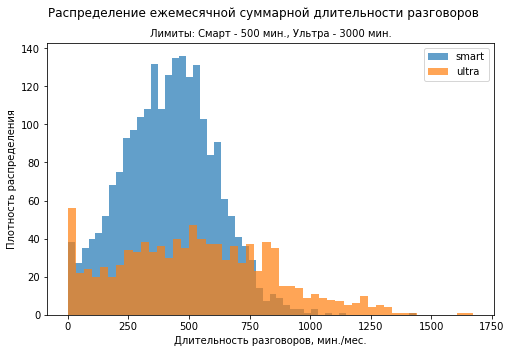

In [45]:
#выведем гистограммы распределения

monthly_consumption.groupby('tariff')['calls_minutes_sum'].plot(kind='hist', bins=50, alpha=0.7, legend=True, figsize=(8, 5));
plt.xlabel('Длительность разговоров, мин./мес.')
plt.ylabel('Плотность распределения')
plt.suptitle('Распределение ежемесячной суммарной длительности разговоров', fontsize=12)
plt.title('Лимиты: Смарт - 500 мин., Ультра - 3000 мин.', fontsize=10)
plt.show()


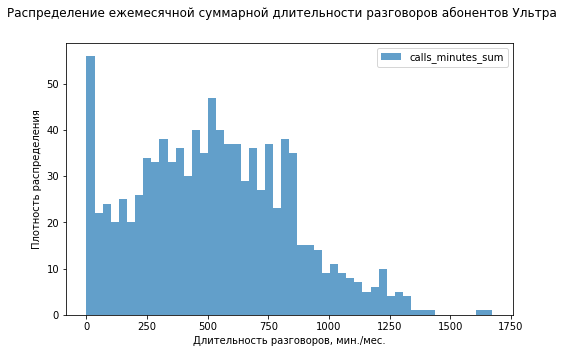

In [46]:
monthly_consumption.loc[monthly_consumption['tariff'] == 'ultra'].plot(y='calls_minutes_sum', kind='hist', bins=50, alpha=0.7, legend=True, figsize=(8, 5));
plt.xlabel('Длительность разговоров, мин./мес.')
plt.ylabel('Плотность распределения')
plt.suptitle('Распределение ежемесячной суммарной длительности разговоров абонентов Ультра', fontsize=12)
plt.show()

Видно, что гистограмма для длительности разговоров Смарта более узкая и напоминает срезанное нормальное распределение. Около трети, как было сказано ранее, лежит выше лимита на разговоры.</br>
Длительность разговоров Ультры гораздо сильнее размазана, пик выражен достаточно слабо. Почти все значения находятся ниже 1500 - это в 2 раза меньше, чем доступный лимит в 3000 минут. </br>
Пики в районе нуля обозначают, что на обоих тарифах есть абоненты, которые вообще не пользуются звонками. Причем на Ультре их заметно больше - вероятно, решающим при выборе тарифа для этих пользователей был объем доступного трафика (вряд ли 1000 бесплатных смс).</br>

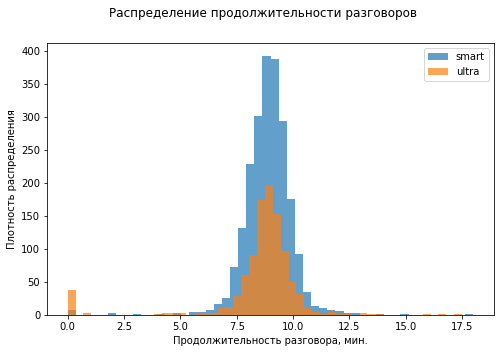

In [47]:
monthly_consumption.groupby('tariff')['mean_call_duration'].plot(kind='hist', bins=50, alpha=0.7, legend=True, figsize=(8, 5));
plt.xlabel('Продолжительность разговора, мин.')
plt.ylabel('Плотность распределения')
plt.suptitle('Распределение продолжительности разговоров', fontsize=12)
plt.show()

Видно, что длительность разговоров не зависит от тарифа и, скорее всего, может быть описана нормальным распределением.

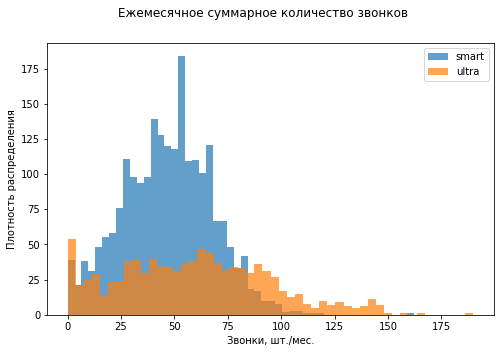

In [48]:
monthly_consumption.groupby('tariff')['calls_sum'].plot(kind='hist', bins=50, alpha=0.7, legend=True, figsize=(8, 5));
plt.xlabel('Звонки, шт./мес.')
plt.ylabel('Плотность распределения')
plt.suptitle('Ежемесячное суммарное количество звонков', fontsize=12)
plt.show()

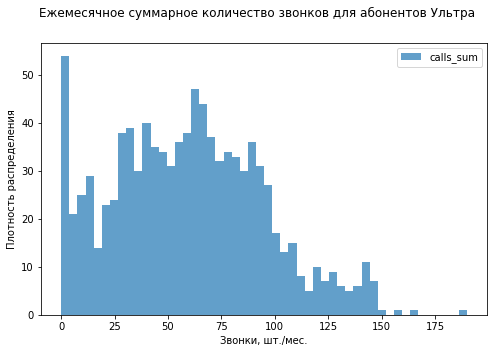

In [49]:
monthly_consumption.loc[monthly_consumption['tariff'] == 'ultra'].plot(y='calls_sum', kind='hist', bins=50, alpha=0.7, legend=True, figsize=(8, 5));
plt.xlabel('Звонки, шт./мес.')
plt.ylabel('Плотность распределения')
plt.suptitle('Ежемесячное суммарное количество звонков для абонентов Ультра', fontsize=12)
plt.show()

С количеством звонков картина похожая на картину с продолжительностью - на Смарте есть выраженный пик и само распределение заметно уже, чем у Ультры, где имеют более широкое распределение. 

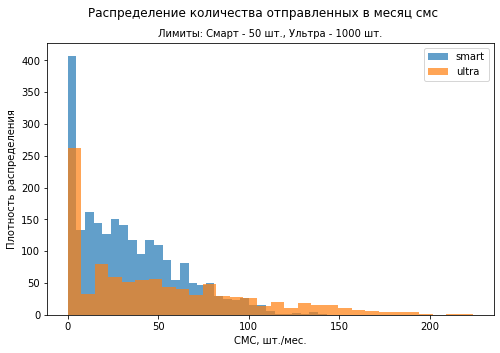

In [50]:
monthly_consumption.groupby('tariff')['messages_sum'].plot(kind='hist', bins=30, alpha=0.7, legend=True, figsize=(8, 5));
plt.xlabel('СМС, шт./мес.')
plt.ylabel('Плотность распределения')
plt.suptitle('Распределение количества отправленных в месяц смс', fontsize=12)
plt.title('Лимиты: Смарт - 50 шт., Ультра - 1000 шт.', fontsize=10)
plt.show()

Заметное количество пользователей на обоих тарифах вообще не пользуется смс-ками.</br>
При этом распределение Ультры имеет более выраженный хвост в область больших значений - т.е. высокий лимит на смс располагает к более активной их отправке.

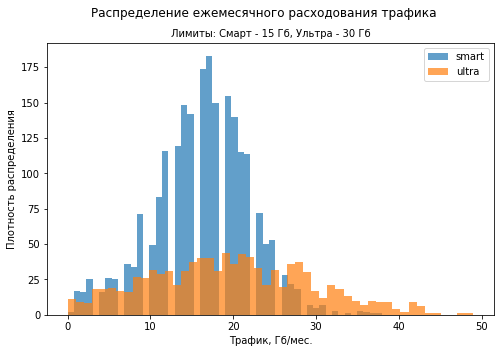

In [51]:
monthly_consumption.groupby('tariff')['gb_used'].plot(kind='hist', bins=50, alpha=0.7, legend=True, figsize=(8, 5));

plt.xlabel('Трафик, Гб/мес.')
plt.ylabel('Плотность распределения')
plt.suptitle('Распределение ежемесячного расходования трафика', fontsize=12)
plt.title('Лимиты: Смарт - 15 Гб, Ультра - 30 Гб', fontsize=10)
plt.show()

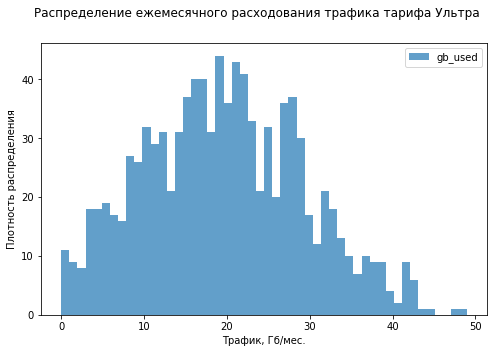

In [52]:
monthly_consumption.loc[monthly_consumption['tariff'] == 'ultra'].plot(y='gb_used', kind='hist', bins=50, alpha=0.7, figsize=(8, 5));
plt.xlabel('Трафик, Гб/мес.')
plt.ylabel('Плотность распределения')
plt.suptitle('Распределение ежемесячного расходования трафика тарифа Ультра', fontsize=12)
plt.show()

В целом, можно сказать, что по форме эти распределения похожи - то есть касательно использования трафика пользователи обоих тарифов ведут себя похоже. При этом фактически пик распределения для тарифа Смарта лежит правее установленного лимита в 15 Гб - это еще раз показывает, что пользователи частенько превышают этот объем. А вот пик Ультры лежит лишь немногим правее - несмотря на то, что лимит больше в 2 раза, большая часть абонентов не расходует его полностью.

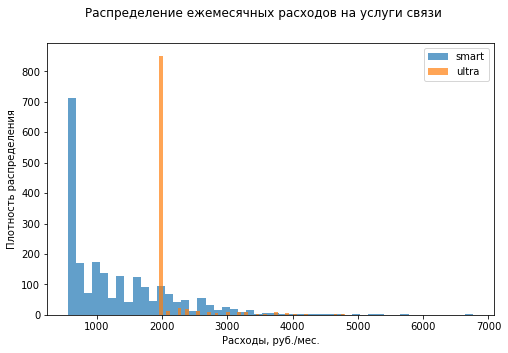

In [53]:
monthly_consumption.groupby('tariff')['monthly_income'].plot(kind='hist', bins=50, alpha=0.7, legend=True, figsize=(8, 5));
plt.xlabel('Расходы, руб./мес.')
plt.ylabel('Плотность распределения')
plt.suptitle('Распределение ежемесячных расходов на услуги связи', fontsize=12)
plt.show()

Здесь видно, что пользователи Ультры гораздо чаще укладываются в "голую" абонентскую плату, в то же время пользователей, укладывающихся в лимиты на Смарте, намного меньше, а дополнительные расходы превышают абонентскую плату у большинства. 

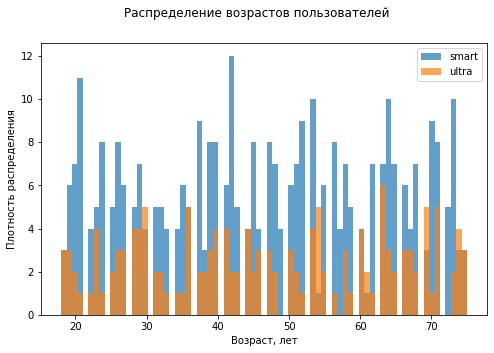

In [54]:
#напоследок изучим распределение возрастов для различных тарифов

users.groupby('tariff')['age'].plot(kind='hist', bins=75, alpha=0.7, figsize=(8, 5), legend=True);
#users['age'].plot(kind='hist', bins=75, alpha=0.5, legend=True);
plt.xlabel('Возраст, лет')
plt.ylabel('Плотность распределения')
plt.suptitle('Распределение возрастов пользователей', fontsize=12)
plt.show()

Каких-то выраженных пиков для того или иного тарифа не заметно - их оба используют пользователи совершенно разных возрастов.

### Проверяем гипотезы

Ответим на два вопроса, важных для исследования: различается ли выручка тарифов и различается ли выручка для Москвы и других регионов.</br>
</br>
</br>
**Различается ли средняя выручка тарифов?**</br>
Есть две выборки из генеральных совокупностей - пользователи тарифа Смарт и пользователи тарифа Ультра. Они выбирают тариф независимо друг от друга, значит генеральные совокупности независимы.</br>
Выборки разного размера; их рассмотрение выше показало разную дисперсию - значи при проверке гипотезы будем считать дисперсии отдельно.</br>
</br>
**Нулевая гипотеза:** средняя месячная выручка по тарифу Смарт равна средней месячной выручке по тарифу Ультра.</br>
**Альтернативная гипотеза:** средняя месячная выручка по этим тарифам не равна.</br>
Выберем уровень значимости 0.001. Уровень значимости показывает максимальную вероятность случайного получения такого результата. Для изучения тарифов мы используем очень большую выборку с данными о звонках, смс и использовании трафика, а значит вероятность случайных искажений в ней мала и нулевую гипотезу мы можем отвергнуть только при очень низком уровне значимости. </br>
</br>
**Различается ли выручка в Москве и других регионах?**</br>
Есть две выборки из генеральных совокупностей - пользователи из Москвы и пользователи из остальных регионов. Они пользуются услугами связи без влияния друг на друга, значит генеральные совокупности независимы.</br>
Выборки разного размера; их рассмотрение выше показало разную дисперсию - значи при проверке гипотезы будем считать дисперсии отдельно.</br>
</br>
**Нулевая гипотеза:** средняя месячная выручка в Москве равна средней месячной выручке в регионах.</br>
**Альтернативная гипотеза:** средняя месячная выручка по выбранным регионам (Москва vs остальные) не равна.</br>
Выберем уровень значимости 0.001. Уровень значимости показывает максимальную вероятность случайного получения такого результата. Для изучения тарифов мы используем очень большую выборку с данными о звонках, смс и использовании трафика, а значит вероятность случайных искажений в ней мала и нулевую гипотезу мы можем отвергнуть только при очень низком уровне значимости. </br>


In [55]:
#определим функцию, которая будет принимать на вход p-value и уровень значимости, сравнивать их и отвергать/нет нулевую гипотезу

def verdict(pvalue, alpha):
    print('pvalue = ', pvalue, ';', 'alpha =', alpha)
    if pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [56]:
#определим две выборки по тарифам
smart_users = monthly_consumption.query('tariff == "smart" ')['monthly_income']
ultra_users = monthly_consumption.query('tariff == "ultra" ')['monthly_income']

#определим уровень значимости
alpha = 0.001

#проверим гипотезу t-критерием Стьюдента
results = st.ttest_ind(smart_users, ultra_users, equal_var=False)
verdict(results.pvalue, alpha)

pvalue =  4.2606313931076085e-250 ; alpha = 0.001
Отвергаем нулевую гипотезу


**Нулевая гипотеза отвергнута в пользу альтернативной: данные, полученные на текущей выборке, говорят в пользу того, что средняя выручка на тарифах Смарт и Ультра различается статистически значимо.**

In [57]:
#отберем номера id для юзеров из Москвы
moscow_users = users.query('city == "Москва"')['user_id'].tolist()
print(moscow_users, len(moscow_users))

[1001, 1003, 1007, 1031, 1033, 1038, 1041, 1049, 1051, 1057, 1062, 1065, 1067, 1068, 1077, 1079, 1080, 1081, 1082, 1102, 1108, 1115, 1132, 1141, 1157, 1162, 1163, 1171, 1175, 1178, 1180, 1190, 1194, 1195, 1201, 1203, 1204, 1205, 1206, 1229, 1235, 1236, 1237, 1244, 1245, 1247, 1248, 1254, 1260, 1268, 1275, 1276, 1283, 1286, 1289, 1291, 1296, 1300, 1305, 1308, 1317, 1321, 1331, 1332, 1333, 1335, 1338, 1339, 1341, 1345, 1347, 1348, 1356, 1359, 1367, 1379, 1381, 1385, 1389, 1395, 1400, 1401, 1415, 1422, 1424, 1434, 1435, 1436, 1440, 1445, 1447, 1449, 1450, 1452, 1453, 1461, 1476, 1481, 1490] 99


In [58]:
#разделим выборку по критерию Москва/ не Москва
sample_moscow = monthly_consumption.query('user_id in @moscow_users')['monthly_income']
sample_not_moscow = monthly_consumption.query('user_id not in @moscow_users')['monthly_income']

#проверим гипотезу о равенстве средних t-критерием Стьюдента
results = st.ttest_ind(sample_moscow, sample_not_moscow, equal_var=False)
verdict(results.pvalue, alpha)

pvalue =  0.5257376663729298 ; alpha = 0.001
Не получилось отвергнуть нулевую гипотезу


**Нулевую гипотезу отвергнуть не получилось: данные, полученные на текущей выборке, не пользволяют получить статистически значимых данных, позволяющих отвергнуть тезис о том, что пользователи из Москвы расходуют деньги на средства связи так же, как и жители других регионов.**

### Выводы

- Лимиты, включенные в тариф Смарт, оказываются недостаточными для большинства клиентов, что приводит к дополнительным тратам помимо абонентской платы.
- Лимиты на звонки и сообщения тарифа Ультра достаточны для 100% пользователей, дополнительные траты происходят только за счет расходования трафика.
- Пользователи тарифа Смарт в среднем тратят на услуги связи ежемесячно 1023 рубля, а пользователи Ультры - 1950.
- Тариф Ультра приносит больше выручки, чем тариф Смарт, несмотря на то, что на Смарте 75% клиентов несут дополнительные расходы, а на Ультре - только 18%.
- На текущей выборке не удалось обнаружить существенного различия в характере расходования средств между пользователями Москвы и других регионов.

По результатам исследования на предоставленных данных более прибыльным для компании на всей охваченной территории является тариф "Ультра".